This notebook downloads the newest public SSI data and computes the test-adjusted incidence rates

In [58]:
import pandas as pd
import numpy as np

import matplotlib        as mpl
import matplotlib.pyplot as plt
import matplotlib.dates  as mdates

import datetime
import urllib
import re
import os
from zipfile import ZipFile
from io import BytesIO

import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
pandas2ri.activate()

plt.style.use('ggplot')

font = {'family' : 'normal',
        'size'   : 18}

mpl.rc('font', **font)


# Defining some helper functions:

In [59]:
def save_dataframe(df, path, filename) :
    if not os.path.exists(path) :
        os.makedirs(path)

    df.to_csv(os.path.join(path, filename))

In [60]:
def load_municipality_test_data(zfile) :
    D = pd.read_csv(zfile.open('Municipality_tested_persons_time_series.csv'), sep=';', index_col=0)
    return D.rename(columns={'Copenhagen': 'København'})

def load_municipality_case_data(zfile) :
    D = pd.read_csv(zfile.open('Municipality_cases_time_series.csv'), sep=';', index_col=0)
    return D.rename(columns={'Copenhagen': 'København'})

def load_municipality_summery_data(zfile) :
    D = pd.read_csv(zfile.open('Municipality_test_pos.csv'), sep = ';', index_col=0, usecols=['Kommune_(navn)','Befolkningstal'], dtype={'Befolkningstal': 'str'})
    return D['Befolkningstal'].str.replace('.','', regex=False).astype(int)

In [61]:
def newest_SSI_filename() :

    date = datetime.datetime.now()
    if date.hour < 14 :
        date -= datetime.timedelta(days=1)

    return date.strftime('%Y_%m_%d')

In [62]:
def SSI_data_missing(filename) :
    # Check if it is already downloaded
    # If it does not exist return flag
    if not os.path.exists(filename) :
        return True
    else :
        return False


In [63]:
def download_SSI_data(date=None,
                      download_municipality_tests=True,
                      path_municipality_tests=None,
                      download_municipality_cases=True,
                      path_municipality_cases=None,
                      download_municipality_summery=True,
                      path_municipality_summery=None) :

    url = 'https://covid19.ssi.dk/overvagningsdata/download-fil-med-overvaagningdata'

    with urllib.request.urlopen(url) as response :
        html = str(response.read())

    date_SSI = datetime.datetime.strptime(date, '%Y_%m_%d').strftime('%d%m%Y')

    s = re.search(f'rapport-{date_SSI}', html, re.IGNORECASE)
    if s is None :
        raise ValueError(f'No data found for date: {date}')

    data_url = html[s.start()-80:s.end()+5]
    data_url = data_url.split('="')[1] + ".zip"

    filename = date + '.csv'

    with ZipFile(BytesIO(urllib.request.urlopen(data_url).read())) as zfile :

        if download_municipality_tests :
            df = load_municipality_test_data(zfile)
            save_dataframe(df, path_municipality_tests, filename)

        if download_municipality_cases :
            df = load_municipality_case_data(zfile)
            save_dataframe(df, path_municipality_cases, filename)

        if download_municipality_summery :
            df = load_municipality_summery_data(zfile)
            save_dataframe(df, path_municipality_summery, filename)


In [64]:
def get_SSI_data(date='newest', return_data=False, return_name=False, verbose=False) :

    if date.lower() == 'newest' :
        date = newest_SSI_filename()

    filename = date + '.csv'

    f_municipality_tests   = os.path.join('municipalityTests',   filename)
    f_municipality_cases   = os.path.join('municipalityCases',   filename)
    f_municipality_summery = os.path.join('municipalitySummery', filename)

    download_municipality_tests   = SSI_data_missing(f_municipality_tests)
    download_municipality_cases   = SSI_data_missing(f_municipality_cases)
    download_municipality_summery = SSI_data_missing(f_municipality_summery)

    if download_municipality_tests or download_municipality_cases or download_municipality_summery :

        if verbose:
            print("Downloading new data")

        download_SSI_data(date=date,
                          download_municipality_tests=download_municipality_tests,
                          path_municipality_tests=os.path.dirname(f_municipality_tests),
                          download_municipality_cases=download_municipality_cases,
                          path_municipality_cases=os.path.dirname(f_municipality_cases),
                          download_municipality_summery=download_municipality_summery,
                          path_municipality_summery=os.path.dirname(f_municipality_summery))

    if return_data :
        # Load the dataframes
        df_municipality_tests   = pd.read_csv(f_municipality_tests,   index_col=0)
        df_municipality_cases   = pd.read_csv(f_municipality_cases,   index_col=0)
        df_municipality_summery = pd.read_csv(f_municipality_summery, index_col=0)

        return df_municipality_cases, df_municipality_tests, df_municipality_summery

    if return_name :
        return date

In [65]:
date = newest_SSI_filename()
Pm, Tm, Dm = get_SSI_data(date=date, return_data=True)
Dm = Dm.transpose()

# Ensure overlap
t1 = pd.to_datetime(Tm.index)
t2 = pd.to_datetime(Pm.index)

intersec = t1.intersection(t2)

Tm = Tm.loc[t1.isin(intersec)]
Pm = Pm.loc[t2.isin(intersec)]

t = pd.to_datetime(Tm.index)

Tm.index = t
Pm.index = t

T = Tm.sum(axis=1)
P = Pm.sum(axis=1)


# Set the analysis parameters

In [66]:
beta = 0.55

# Choose interval
end_date   = datetime.datetime.strptime(date, '%Y_%m_%d').date() - datetime.timedelta(days=2)
start_date = end_date - datetime.timedelta(days=90)

tt = pd.date_range(start=start_date, end=end_date, freq='d')

# Plot the number of daily PCR tests

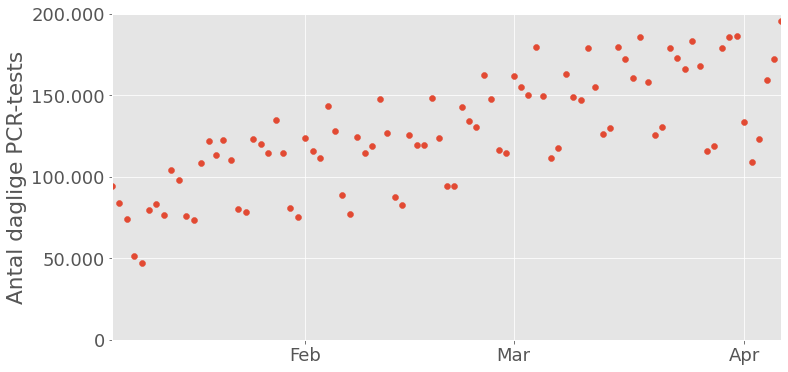

In [67]:
plt.figure(figsize=(12, 6))
plt.scatter(t, T)

ax = plt.gca()

months     = mdates.MonthLocator()
months_fmt = mdates.DateFormatter('%b')

ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(months_fmt)

plt.ylabel('Antal daglige PCR-tests')
plt.ylim(0, 200_000)
plt.locator_params(axis='y', nbins=6)

ax.get_yaxis().set_major_formatter(
mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',').replace(',','.')))

plt.xlim(start_date, end_date)

plt.savefig(f'National_test_counts_{date}.png')
plt.show()


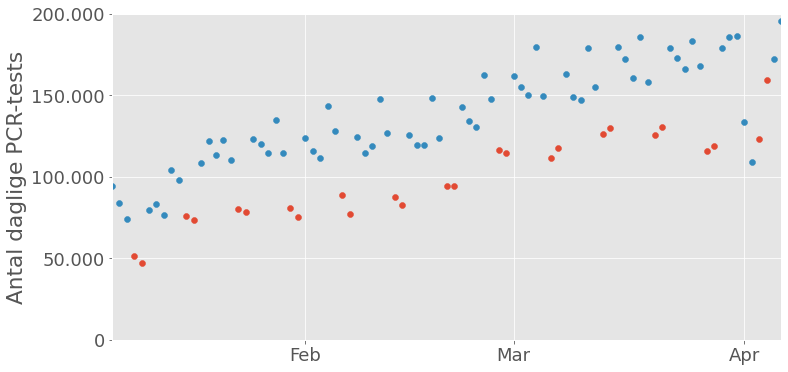

In [68]:
plt.figure(figsize=(12, 6))
plt.scatter(t[t.weekday >= 5], T[t.weekday >= 5])
plt.scatter(t[t.weekday < 5], T[t.weekday < 5])

ax = plt.gca()

months     = mdates.MonthLocator()
months_fmt = mdates.DateFormatter('%b')

ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(months_fmt)

plt.ylabel('Antal daglige PCR-tests')
plt.ylim(0, 200_000)
plt.locator_params(axis='y', nbins=6)

ax.get_yaxis().set_major_formatter(
mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',').replace(',','.')))

plt.xlim(start_date, end_date)

plt.savefig(f'National_test_counts_{date}_alternative.png')
plt.show()

# Prepare the GLM predictor

In [69]:
N = 100_000   
dfp = pd.DataFrame([0.55 * np.log(N)], columns=['X'])
rdfp = ro.conversion.py2rpy(dfp)
col = 'Næstved'
df = pd.DataFrame(zip(Tm[col], Pm[col]), columns=['tests', 'pos'], index=t)
df['X'] = 0.55 * np.log(df['tests'])

ind = pd.date_range(end=end_date, periods=7)
rdf = ro.conversion.py2rpy(df.loc[ind])
qpoisson = ro.r.glm('pos ~ 1 + offset(X)', data = rdf, family = ro.r('quasipoisson'))
fit = ro.r.predict(qpoisson, newdata=rdfp, se_fit=True)[0]
cov = ro.r.summary(qpoisson)[-1][0]

np.exp(fit + np.array([0, -2, 2]) * np.sqrt(cov))


C:\Users\RSKE\Miniconda3\lib\site-packages\pandas\core\arraylike.py:274: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


array([26.84581718, 14.19963426, 50.75468048])

In [70]:
def predict(df, start_date, end_date, N=100_000) :
    
    df['X'] = 0.55 * np.log(df['tests'])
    
    dfp = pd.DataFrame([0.55 * np.log(N)], columns=['X'])
    rdfp = ro.conversion.py2rpy(dfp)
    
    # Trin the model on each 7 day period
    out = []
    T = pd.date_range(start=start_date, end=end_date, freq='D') 
    for d in T : 
        ind = pd.date_range(end=d, periods=7)
        rdf = ro.conversion.py2rpy(df.loc[ind])
        qpoisson = ro.r.glm('pos ~ 1 + offset(X)', data = rdf, family = ro.r('quasipoisson'))
        fit = ro.r.predict(qpoisson, newdata=rdfp, se_fit=True)[0]
        cov = ro.r.summary(qpoisson)[-1][0]
        
        out.append(np.squeeze(np.exp(fit + np.array([0, -1, 1]) * np.sqrt(cov))))

    return pd.DataFrame(data=np.array(out), columns=['mean', 'lower', 'upper'], index=T)

In [71]:
def incidence(P, start_date, end_date, N=5_840_000) :

    out = []
    K = len(P)
    
    for d in pd.date_range(start=start_date, end=end_date, freq='D') :
        ind = pd.date_range(end=d, periods=7)
        out.append(P.loc[ind].sum() * 1e5 / N)
    return np.array(out)

# Plot the daily incidence

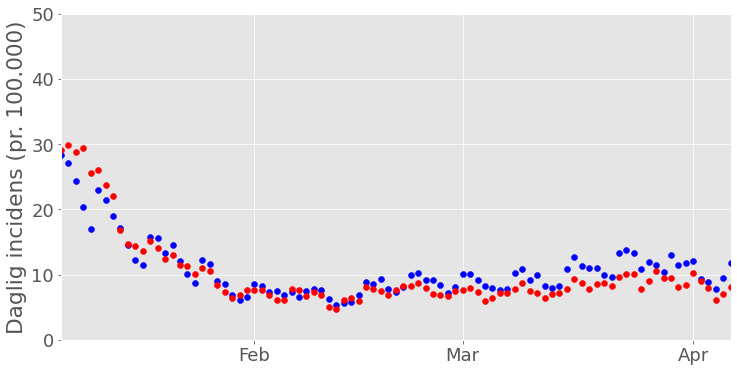

In [72]:
plt.figure(figsize=(12, 6))
plt.scatter(tt, P.loc[tt] * 1e5 / 5_840_000, color='b')
plt.scatter(tt, P.loc[tt] * (1e5 / T.loc[tt]) ** beta * 1e5 / 5_840_000, color='r')

ax = plt.gca()

months     = mdates.MonthLocator()
months_fmt = mdates.DateFormatter('%b')

ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(months_fmt)

plt.ylabel('Daglig incidens (pr. 100.000)')
plt.ylim(0, 50)
plt.locator_params(axis='y', nbins=6)

ax.get_yaxis().set_major_formatter(
mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',').replace(',','.')))

plt.xlim(start_date, end_date)

plt.savefig(f'National_incidence_daily_{date}.png')
plt.show()

# Plot the weekly incidence on national level

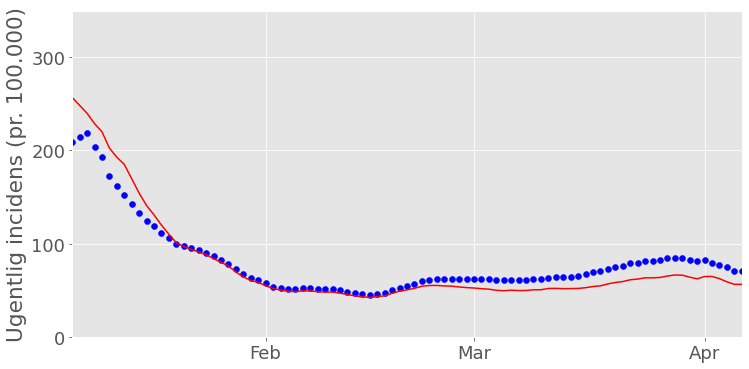

In [73]:
df = pd.DataFrame(zip(T, P), columns=['tests', 'pos'], index=t)

sPglm = predict(df, start_date, end_date) * 1e5 / 5_840_000 * 7
inci  = incidence(P, start_date, end_date)

plt.figure(figsize=(12, 6))
plt.scatter(tt, inci,  color='b')
plt.errorbar(tt, sPglm['mean'], color='r')


ax = plt.gca()

months     = mdates.MonthLocator()
months_fmt = mdates.DateFormatter('%b')

ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(months_fmt)

plt.ylabel('Ugentlig incidens (pr. 100.000)')
plt.ylim(0, 350)
plt.locator_params(axis='y', nbins=6)

ax.get_yaxis().set_major_formatter(
mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',').replace(',','.')))

plt.xlim(start_date, end_date)

plt.savefig(f'National_incidence_weekly_{date}.png')
plt.show()

# Some example municipalities

C:\Users\RSKE\Miniconda3\lib\site-packages\pandas\core\arraylike.py:274: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\RSKE\Miniconda3\lib\site-packages\pandas\core\arraylike.py:274: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\RSKE\Miniconda3\lib\site-packages\pandas\core\arraylike.py:274: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\RSKE\Miniconda3\lib\site-packages\pandas\core\arraylike.py:274: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


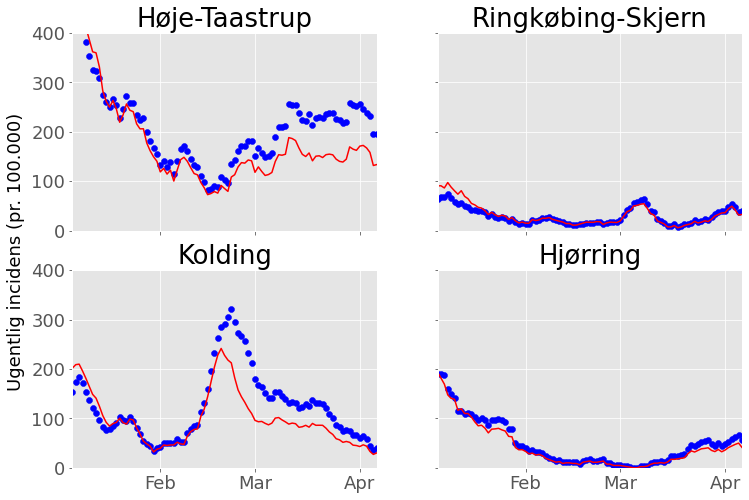

In [74]:
cols = ['Høje-Taastrup', 'Ringkøbing-Skjern', 'Kolding', 'Hjørring']

fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(12, 8))
axes = axes.flatten()

for col, ax in zip(cols, axes) :

    N = Dm[col].to_numpy()[0]

    df = pd.DataFrame(zip(Tm[col], Pm[col]), columns=['tests', 'pos'], index=t)

    sPglm = predict(df, start_date, end_date, N = N * 0.017) * 100_000 / N * 7
    inci  = incidence(Pm[col], start_date, end_date, N = N)

    ax.scatter(tt, inci,  color='b')
    ax.errorbar(tt, sPglm['mean'], color='r')

    ax.set_title(col)

    months     = mdates.MonthLocator()
    months_fmt = mdates.DateFormatter('%b')

    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(months_fmt)

plt.locator_params(axis='y', nbins=6)

ax.get_yaxis().set_major_formatter(
mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',').replace(',','.')))


fig.text(0.06, 0.5, 'Ugentlig incidens (pr. 100.000)', ha='center', va='center', rotation='vertical')
plt.xlim(start_date, end_date)
plt.ylim(0, 400)

plt.savefig(f'Municipality_incidence_weekly_{date}.png')
plt.show()


# Select your own municipality

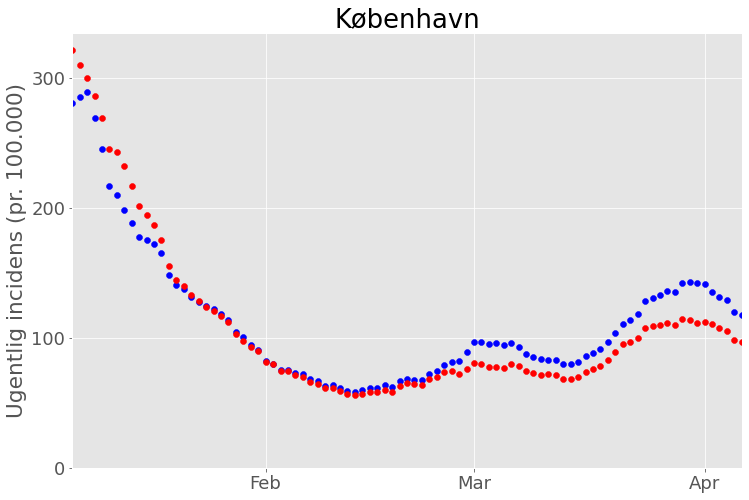

In [75]:
municipality = 'København'

plt.figure(figsize=(12, 8))
ax = plt.gca()

N = Dm[municipality].to_numpy()[0]

df = pd.DataFrame(zip(Tm[municipality], Pm[municipality]), columns=['tests', 'pos'], index=t)

sPglm = predict(df, start_date, end_date, N = N * 0.017) * 100_000 / N * 7
inci  = incidence(Pm[municipality], start_date, end_date, N = N)

ax.scatter(tt, inci,  color='b')
ax.scatter(tt, sPglm['mean'], color='r')

ax.set_title(municipality)

months     = mdates.MonthLocator()
months_fmt = mdates.DateFormatter('%b')

ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(months_fmt)

plt.locator_params(axis='y', nbins=6)

ax.get_yaxis().set_major_formatter(
mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',').replace(',','.')))

plt.ylabel('Ugentlig incidens (pr. 100.000)')
plt.xlim(start_date, end_date)
plt.ylim(0, None)

plt.savefig(f'{municipality}_incidence_weekly_{date}.png')
plt.show()
